## Check for Programmatic variations


Matching Statistics for Sent_flat:
Number of matches in Sent_flat: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Precision: 0.1786
Recall: 0.5786
F1 Score: 0.2729

Matching Statistics for Sent_upgraded:
Number of matches in Sent_upgraded: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Precision: 0.7975
Recall: 0.8189
F1 Score: 0.8080

Matching Statistics for TransE.65:
Number of matches in TransE.65: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 773
Percentage Matched (%): 82.41

Precision: 0.8052
Recall: 0.8267
F1 Score: 0.8158

Matching Statistics for Distmult.5:
Number of matches in Distmult.5: 773
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 788
Percentage Matched (%): 84.01

Precision: 0.8082
Recall: 0.8419
F1 Score: 0.8247

Matching Statistics for Node2vec.5:
Number of matches in Node2vec.5: 737
Total Duplicates

,Precision,Recall,F1 Score
Sent_flat,0.1786,0.5786,0.2729
Sent_upgraded,0.7975,0.8189,0.8080
TransE.65,0.8052,0.8267,0.8158
Distmult.5,0.8082,0.8419,0.8247
Node2vec.5,0.8436,0.8463,0.8450
NetMf.8,0.8483,0.7949,0.8207
DeepWalk.8,0.8062,0.8321,0.8189


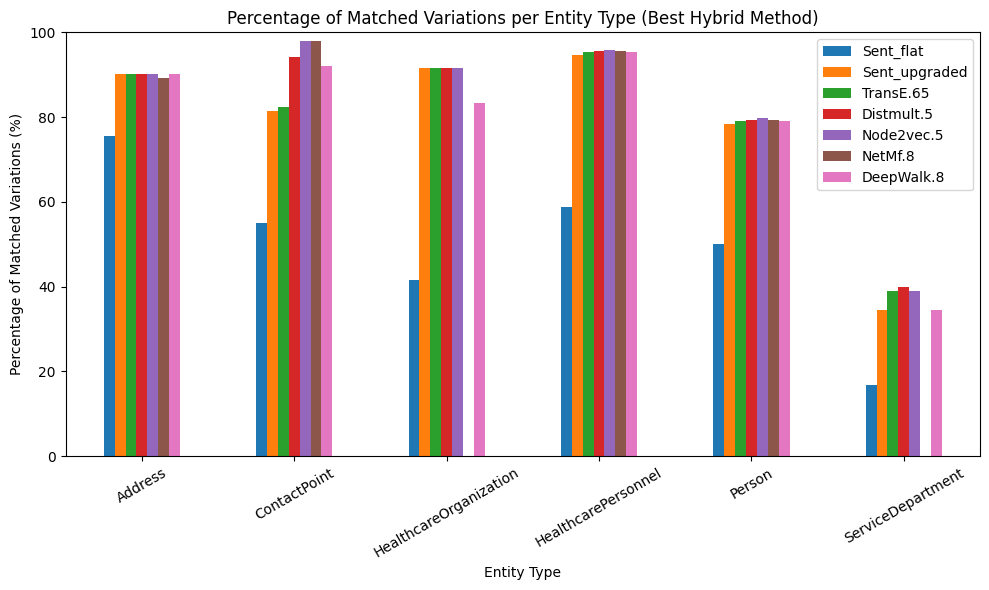

In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Sent_flat': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_upgraded': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE.65' : json.load(open('matches/HybridTransE_alpha_0.65.json', 'r')),
    'Distmult.5': json.load(open('matches/HybridDistmult_alpha_0.5.json', 'r')),
    'Node2vec.5': json.load(open('matches/HybridNode2vec_alpha_0.5.json', 'r')),
    'NetMf.8' : json.load(open('matches/HybridNetMf_alpha_0.8.json', 'r')),
    'DeepWalk.8' : json.load(open('matches/HybridDeepWalk_alpha_0.8.json', 'r')),    
}

def extract_uuid(uri):
    return uri.split("/")[-1]
precision_recall_summary = {} 
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })
    # Calculate precision and recall
    # True Positives (TP): matched pairs that are in golden_standard
    TP = matched
    # False Positives (FP): matched pairs that are NOT in golden_standard
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    FP = len(matched_pairs_set - golden_pairs_set)
    # False Negatives (FN): golden_standard pairs not matched
    FN = len(golden_pairs_set - matched_pairs_set)
    
    # precision, recall, and F1 score calculations
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall, 'F1 Score': F1_score}

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\f")
    print(f"F1 Score: {F1_score:.4f}\n")

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched

pr_df = pd.DataFrame(precision_recall_summary).T  # Transpose for better display
pr_df = pr_df.round(4)
print("Precision and Recall per Method:")
display(pr_df)

percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (Best Hybrid Method)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   

In [3]:
# Find all golden standard matches that were NOT found by the last algorithm run in the loop
missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

print(f"Number of missed matches: {len(missed_rows)}")
missed_rows.head()  # Show a sample

Number of missed matches: 237


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
4,603fa8f0-1549-4dee-830b-4d6d9575d095,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
8,eae9c546-446c-4893-89d3-cdb9ebb9aa72,86e83feb-1163-40a8-aaf2-f91817533642,Address,postal_format,postalCode,6850 ER,6850ER
10,335be677-df1b-425e-af66-be879a4c2227,cb811cf8-aa07-4228-9eb8-19928c81bfd9,Address,postal_format,postalCode,8883 YA,8883YA
14,5a8fe4b2-8ffd-4977-85b8-93b04d36c61a,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
16,71494031-67ef-4e9e-803f-00347399a177,ef025bd0-46d6-485f-96cd-cf3680d42938,Address,postal_format,postalCode,9277 GF,9277GF


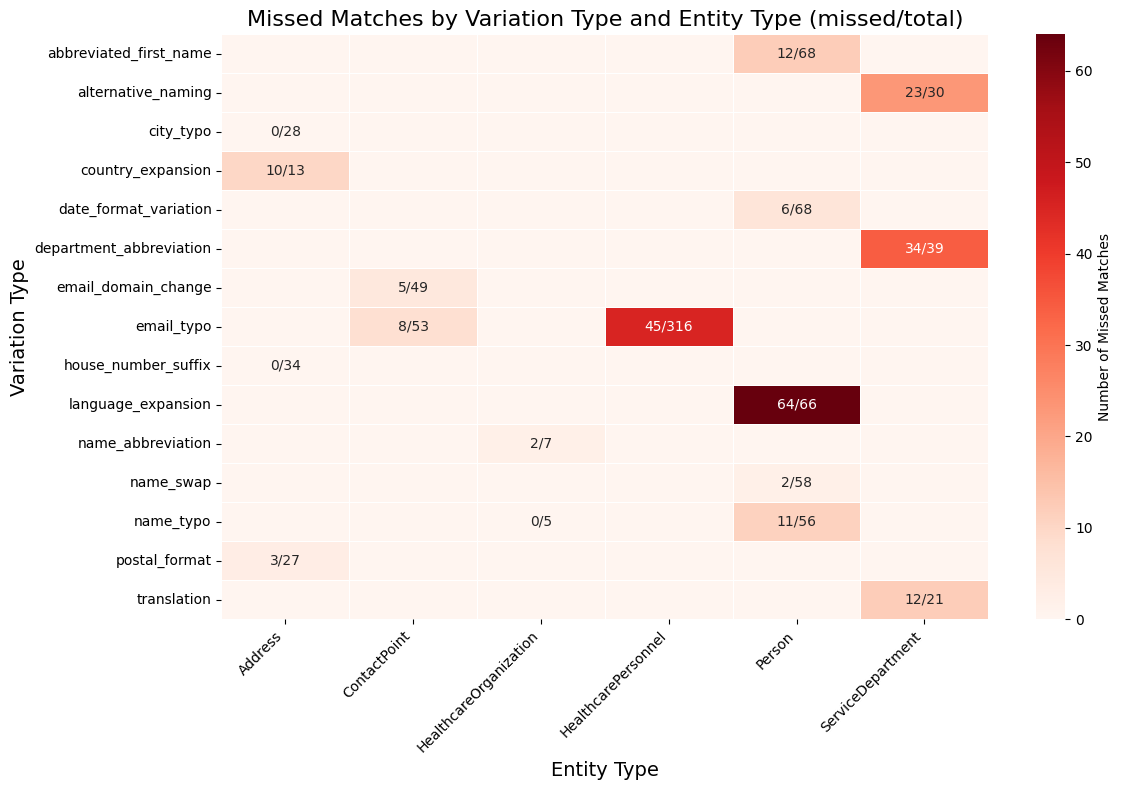

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missed_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

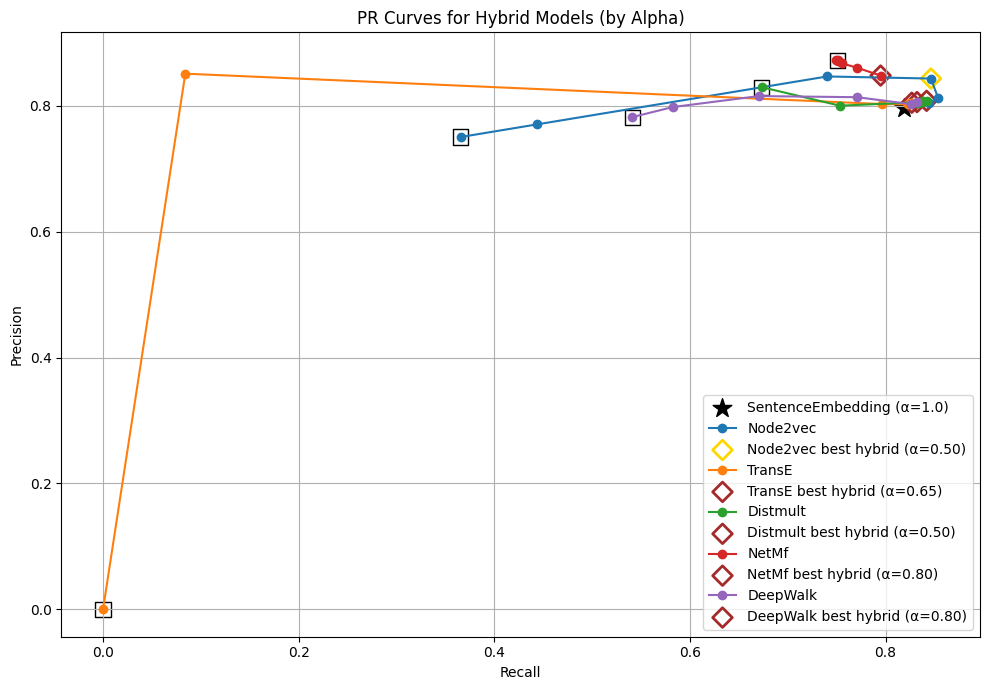

In [8]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Path and file setup
match_dir = "matches"
model_bases = {
    'Node2vec': "HybridNode2vec_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
    'DeepWalk': "HybridDeepWalk_alpha_"
}
alpha_values = [0.0, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) or
                (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])
                for pair in identifiers
            ),
            axis=1
        )
    ]
    TP = len(matched_rows)
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    FP = len(matched_pairs_set - golden_pairs_set)
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(10, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    plt.plot(hybrid_recalls, hybrid_precisions, marker='o', label=model)
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else 'brown'
        plt.scatter(hybrid_recalls[best_idx_model], hybrid_precisions[best_idx_model], marker='D', s=100, edgecolor=marker_color, facecolor='none', linewidths=2, label=f"{model} best hybrid (α={hybrid_alphas[best_idx_model]:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Hybrid Models (by Alpha)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Matching Statistics for TransE:
Number of matches in TransE: 0
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 0
Percentage Matched (%): 0.00

Matching Statistics for Distmult:
Number of matches in Distmult: 569
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 590
Percentage Matched (%): 62.90

Matching Statistics for Node2vec:
Number of matches in Node2vec: 354
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 271
Percentage Matched (%): 28.89

Matching Statistics for NetMf:
Number of matches in NetMf: 607
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 685
Percentage Ma

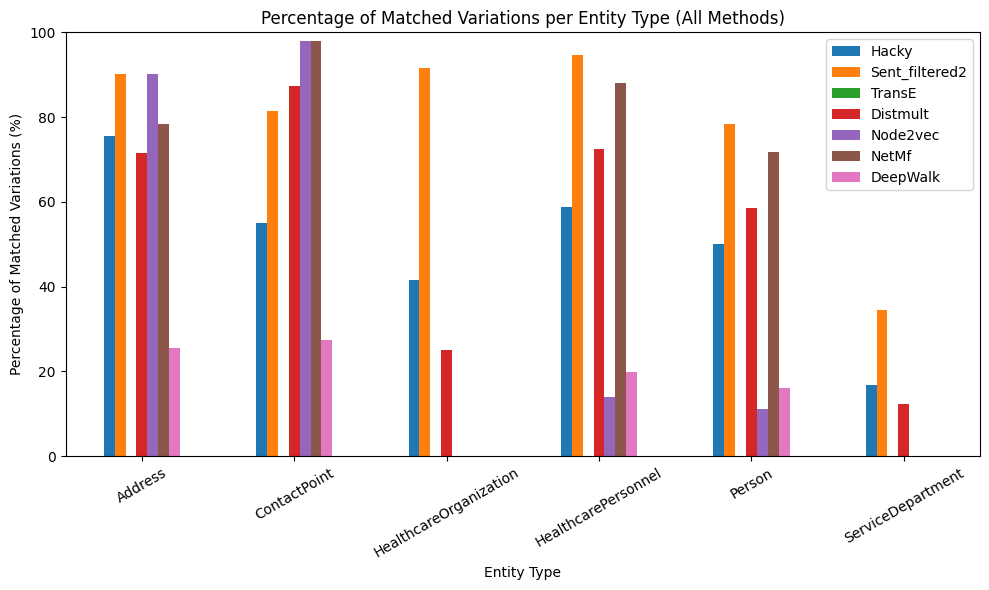

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Sent_flat': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_upgraded': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches/HybridTransE_alpha_0.0.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_alpha_0.0.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_alpha_0.0.json', 'r')),
    'NetMf' : json.load(open('matches/HybridNetMf_alpha_0.0.json', 'r')),
    'DeepWalk' : json.load(open('matches/HybridDeepWalk_alpha_0.0.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched


percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   